In [3]:
import pandas as pd
import numpy as np

from datetime import datetime as dt
from datetime import timedelta

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [41]:
# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article
GAMMA = 1/4

# Skip last 5 days since the THL data is incomplete for the last few days
SKIP_N_LAST_DAYS_IN_DATA = 5
# How many days of history used as posterior
DAYS_USED_IN_POSTERIOR = 7

In [42]:
def highest_density_interval(pmf, p=.95):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=['Low', 'High'])

In [43]:
def get_data_from_RKI():
    url = 'https://covid19publicdata.blob.core.windows.net/rki/covid19-germany-federalstates.csv'
    germany = pd.read_csv(url)
    germany['date'] = germany['date'].apply(pd.to_datetime).dt.date
    germany.set_index(germany['date'], inplace=True)
    germany = germany[['federalstate', 'infections', 'newinfections']]
    germany = germany.groupby('date').sum()
    return germany

germany = get_data_from_RKI()
germany

,infections,newinfections
date,,
2020-02-28,53,53
2020-02-29,64,11
2020-03-01,127,63
2020-03-02,155,28
2020-03-03,196,41
...,...,...
2020-06-18,187764,580
2020-06-19,188534,770
2020-06-20,189135,601


In [7]:
def get_all_data_from_RKI():
    url = 'https://covid19publicdata.blob.core.windows.net/rki/covid19-germany-federalstates.csv'
    germany = pd.read_csv(url)
    germany['date'] = germany['date'].apply(pd.to_datetime).dt.date
    germany = germany.groupby('date').sum()
    return germany

germany = get_all_data_from_RKI()

,date,id,infections,deaths,newinfections,newdeaths
0,2020-02-28,136,53,0,53,0
1,2020-02-29,392,64,0,11,0
2,2020-03-01,648,127,0,63,0
3,2020-03-02,904,155,0,28,0
4,2020-03-03,1160,196,0,41,0
...,...,...,...,...,...,...
114,2020-06-21,29320,189822,8882,687,-1
115,2020-06-22,29576,190359,8885,537,3
116,2020-06-23,29832,190862,8895,503,10
117,2020-06-24,30088,191449,8914,587,19


In [6]:
url = 'https://covid19publicdata.blob.core.windows.net/rki/covid19-germany-federalstates.csv'
germany = pd.read_csv(url)
germany

,id,Country/Region,federalstate,infections,deaths,date,newinfections,newdeaths
0,1,Germany,Baden-Württemberg,10,0,2020-02-28,10,0
1,2,Germany,Bavaria,15,0,2020-02-28,15,0
2,3,Germany,Berlin,0,0,2020-02-28,0,0
3,4,Germany,Brandenburg,0,0,2020-02-28,0,0
4,5,Germany,Bremen,0,0,2020-02-28,0,0
...,...,...,...,...,...,...,...,...
1899,1900,Germany,Saarland,2801,169,2020-06-25,0,0
1900,1896,Germany,Saxony,5438,223,2020-06-25,2,1
1901,1891,Germany,Saxony-Anhalt,1858,58,2020-06-25,2,0
1902,1902,Germany,Schleswig-Holstein,3140,152,2020-06-25,3,0


Index([], dtype='object', name='date')


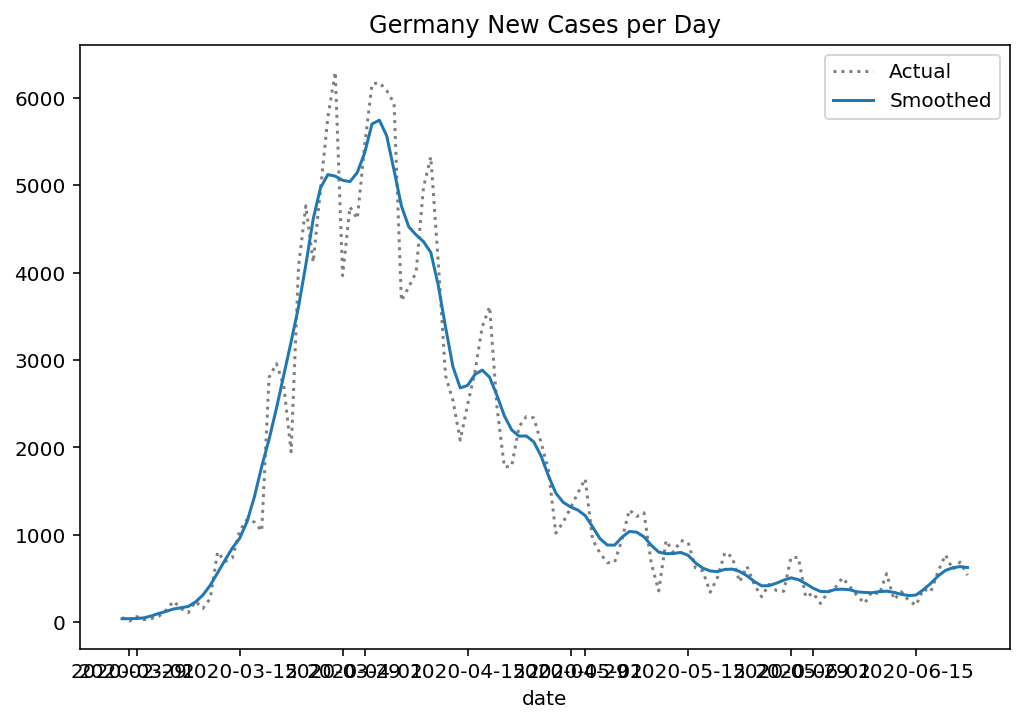

In [44]:
state_name = 'Germany'

def prepare_cases(new_cases):
    # Note that in the origal data, the cases were cumulative
    # The RKI data is per day, so there is no need to take diff
    # new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    print(zeros)
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = germany['newinfections'].rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

In [46]:
def get_posteriors(sr, min_periods=1):
    window=DAYS_USED_IN_POSTERIOR
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

posteriors = get_posteriors(smoothed)

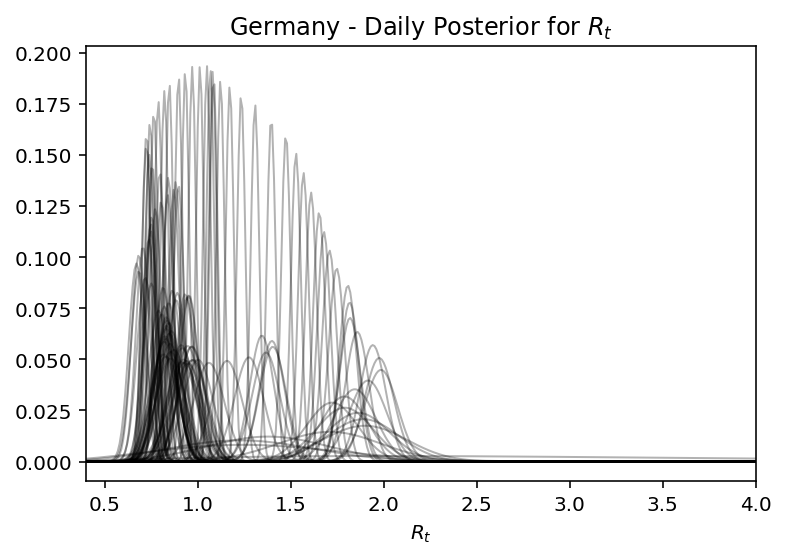

In [47]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,4))

ax.set_xlabel('$R_t$');

In [48]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low,High
date,,,
2020-06-18,1.28,1.12,1.43
2020-06-19,1.37,1.22,1.52
2020-06-20,1.40,1.26,1.54
2020-06-21,1.40,1.27,1.54
2020-06-22,1.34,1.22,1.48


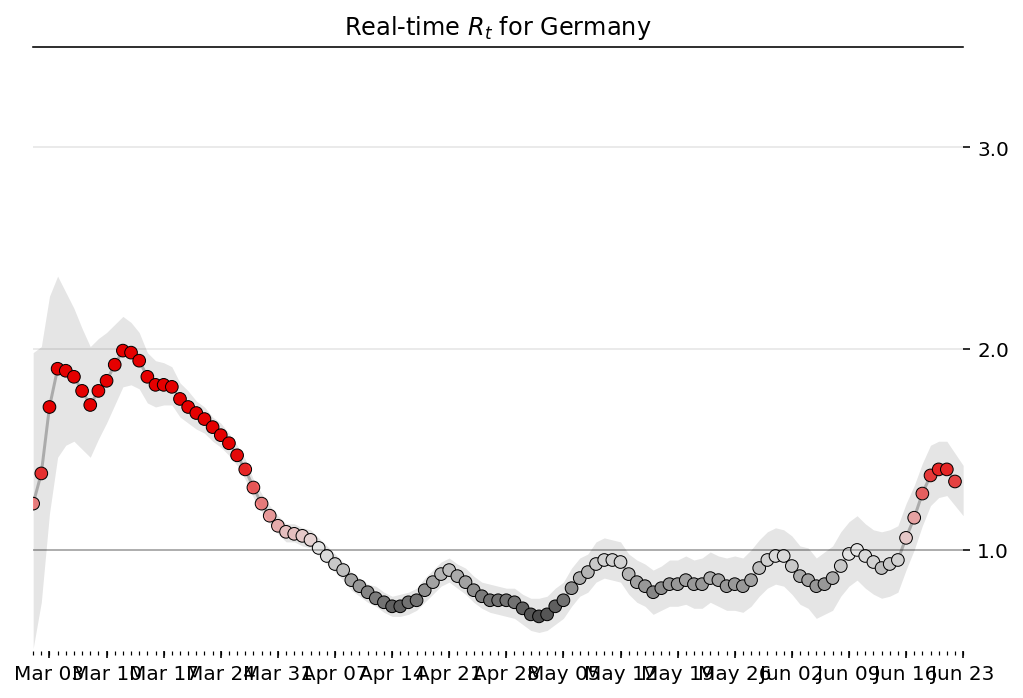

In [73]:
def plot_rt(result_test, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.set_ylim(.5,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))